# WRITING ANTIMONY MODELS

# Preliminaries

In [1]:
!pip install -q tellurium
!pip install -q control
!pip install -q controlSBML

In [18]:
import numpy as np
import tellurium as te
import matplotlib.pyplot as plt

# Using Antimony and Tellurium

## Antimony

Antimony is a language for describing biochemical pathways.
Consider a sequential pathway: $S_1 \xrightarrow{k_1 S_1} S_2 \xrightarrow{k_2 S_2} S_3$, with $S_1 =10$, $k_1 =1, k_2=1$.

In [3]:
MODEL1 = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""

In [4]:
# Loading the simulation
rr = te.loada(MODEL1)

In [20]:
# Running the simulation and collecting the data directly
data = rr.simulate(0, 5, 100) # start time, end time, number of points

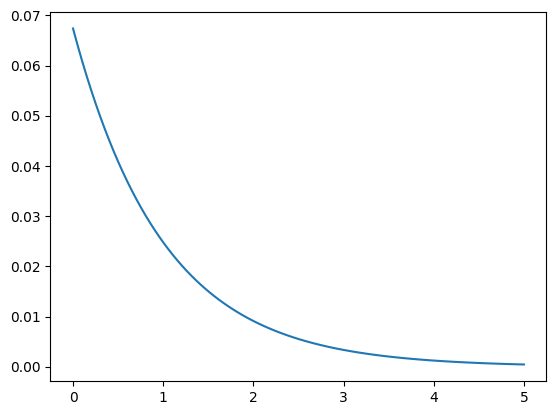

In [22]:
_ = plt.plot(data["time"], data["S1"])

In [7]:
print(rr.getAntimony())

// Created by libAntimony v2.14.0
// Compartments and Species:
species S1, S2, S3;

// Reactions:
_J0: S1 -> S2; k1*S1;
_J1: S2 -> S3; k2*S2;

// Species initializations:
S1 = 10;
S2 = 0;
S3 = 0;

// Variable initializations:
k1 = 1;
k2 = 2;

// Other declarations:
const k1, k2;



# Exploring kinetics in sequential pathway

$S_1 \xrightarrow{k_1 S_1} S_2 \xrightarrow{k_2 S_2} S_3$, with $S_1 =10$, $k_1 =1, k_2=1$.

In [8]:
MODEL2 = """
species S1, S2, S3

$S1 -> S2; k1*S1  # "$S1" means that S1 does not change its value
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""

In [40]:
# Function that adjust model parameters
def plotModel(model=MODEL2, parameter_dct=None, times=np.linspace(0, 5, 50), title="", is_plot=True):
    """
    Plots the simulation with the specified parameter values.

    Parameters
    ----------
    model: str
    parameter_dct: dict
        key: parameter name
        value: parameter value
    is_plot: bool

    Returns
    -------
    NamedArray
    """
    if parameter_dct is None:
        parameter_dct = {}
    rr = te.loada(model)
    for name, value in parameter_dct.items():
        rr[name] = value
    simulation_results = rr.simulate(times[0], times[-1], len(times))
    if is_plot:
        rr.plot(simulation_results, title=title)
    return simulation_results

# TESTS
results = plotModel(is_plot=False)
assert("NamedArray" in str(type(results)))
print("OK")

OK


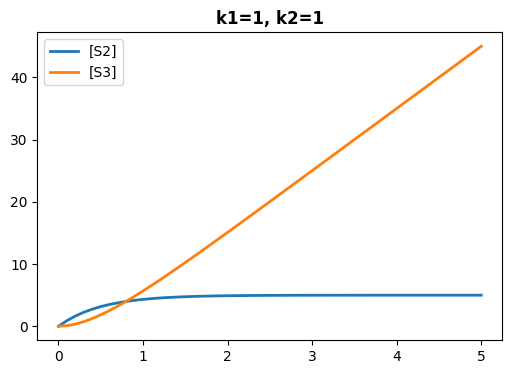

In [10]:
_ = plotModel(title="k1=1, k2=1")

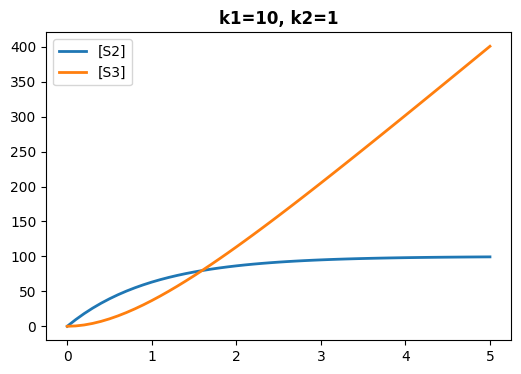

In [11]:
_ = plotModel(parameter_dct={"k1": 10, "k2": 1}, title="k1=10, k2=1")

# Exercise

1. Write a model with the following reactions for $k_1 = k_2 = k_3 = k_4 =1$.
    * $S_1 \xrightarrow{k_1} S_2$
    * $S_2 \xrightarrow{k_2} S_3$
    * $S_3 \xrightarrow{k_3} S_2$
    * $S_3 \xrightarrow{k_4} $

1. Plot the result.

1. What happens when we change $k_1$ to 0.1? 0.5? 1.5? 2.0?

# Accessing models in BioModels

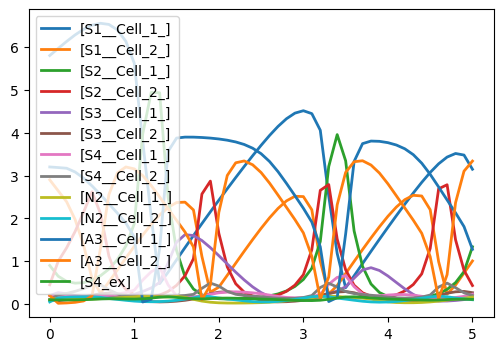

In [12]:
rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000691.3?filename=BIOMD0000000691_url.xml")
rr.simulate()
rr.plot()

In [13]:
print(rr.getAntimony())

// Created by libAntimony v2.14.0
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function function_for_v2(k2, S2, N1)
  k2*S2*N1;
end

function_for_v2 is "function for v2"

function function_for_d_dt_S4_ex(phi, J1, J2)
  (phi/2)*(J1 + J2);
end

function_for_d_dt_S4_ex is "function for d/dt(S4_ex)"

function function_for_v1(k1, S1, A3, K_I, q)
  k1*S1*A3*(1 + (A3/K_I)^q)^-1;
end

function_for_v1 is "function for v1"

function function_for_v3(k3, S3, A2)
  k3*S3*A2;
end

function_for_v3 is "function for v3"


model *Wolf2000___Cellular_interaction_on_glycolytic_oscillations_in_yeast()

  // Compartments and Species:
  compartment Cell_1, Cell_2, Compartment;
  species S1__Cell_1_ in Cell_1, S1__Cell_2_ in Cell_2, S2__Cell_1_ in Cell_1;
  species S2__Cell_2_ in Cell_2, S3__Cell_1_ in Cell_1, S3__Cell_2_ in Cell_2;
  species S4__Cell_1_ in Cell_1, S4__Cell_2_ in Cell_2, N2__Cell_1_ in Cell_1;
  species N2__Cell_2_ in Cell_2,

# Implementing a Controller

Antimony has **assignment variables** that link species concentrations to variables. We can perform arithmetic on assignment variables. Below is an example of reporting the total concentration of ``S1`` and ``S2``.

In [14]:
MODEL1 = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2

total := S1 + S2
"""

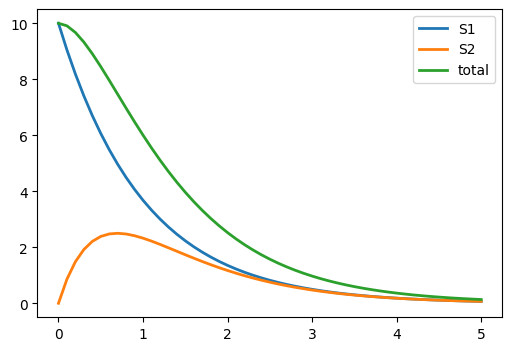

In [15]:
rr = te.loada(MODEL1)
rr.simulate(selections=["time", "S1", "S2", "total"])
rr.plot()

We can implement a proportional controller with ``setpoint` as the desired output for the system that has S1 as input and S3 as the output.
* ``e`` is the control error. ``e := setpoint - S3``
* We calculate ``S1`` from the controller. ``S1 := kP*e``

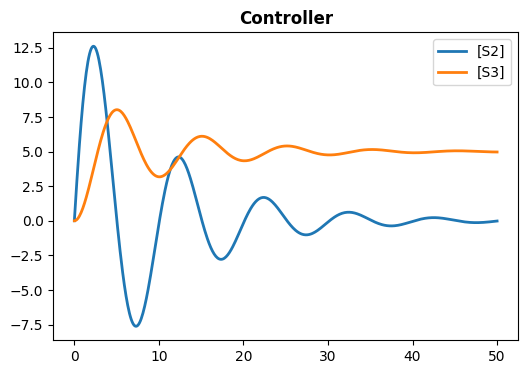

In [57]:
CONTROLLED_MODEL2 = """
species S1, S2, S3

$S1 -> S2; k1*S1
S2 -> S3; k2*S2

S2 = 0
S3 = 0
k1 = 1
k2 = 0.2
setpoint = 0. # Dummy value
kP = 0. # Dummy value

e := setpoint - S3
$S1 := kP*e
"""
_ = plotModel(model=CONTROLLED_MODEL2, times=np.linspace(0, 50, 500),
              parameter_dct=dict(setpoint=5, kP=2), title="Controller")

A more involved model.

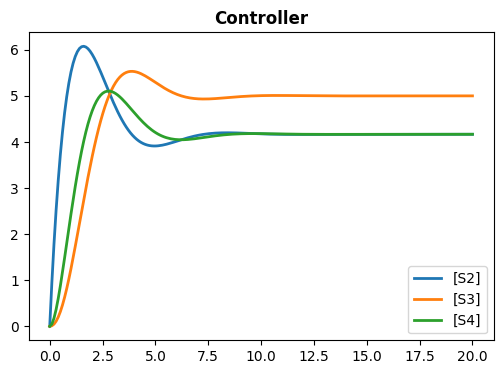

In [55]:
CONTROLLED_MODEL2 = """
species S1, S2, S3

$S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S2; k3*S3
S2 -> S4; k4*S2
S4 ->S3; k5*S4

S1 = 0. # Dummy value
S2 = 0
S3 = 0
k1 = 1
k2 = 0.2
k3 = 1
k4 = 1
k5 = 1
setpoint = 5
kP = 0. # Dummy value

e := setpoint - S3
$S1 := kP*e
"""
_ = plotModel(model=CONTROLLED_MODEL2, times=np.linspace(0, 20, 200),
              parameter_dct=dict(setpoint=5, kP=2), title="Controller")